# Correcting for Imbalanced Data

In [7]:
import joblib
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

In [1]:
# Loading data
# file_path = Path("../data/myopia.csv")
file_path = Path("../eda/reduced_filtered_df.csv")
df = pd.read_csv(file_path)
df.head(5)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,ACD,LT,VCD,SPORTHR,DADMY,delta_spheq,total_positive_screen,MYOPIC
0,3.702,3.392,15.290000,4,1,1.358,8,0
1,3.462,3.514,15.520000,14,0,1.929,10,0
2,3.186,3.654,15.490000,12,1,1.433,16,0
3,3.732,3.584,15.080000,12,0,2.022,8,0
4,3.730,3.322,16.280001,4,0,1.783,9,0


In [2]:
# Check dataset balance
df["MYOPIC"].value_counts()

0    233
1     34
Name: MYOPIC, dtype: int64

In [3]:
# Define X,y
label = df["MYOPIC"]
X = df.iloc[:,:-1].copy()
X.head()

,ACD,LT,VCD,SPORTHR,DADMY,delta_spheq,total_positive_screen
0,3.702,3.392,15.290000,4,1,1.358,8
1,3.462,3.514,15.520000,14,0,1.929,10
2,3.186,3.654,15.490000,12,1,1.433,16
3,3.732,3.584,15.080000,12,0,2.022,8
4,3.730,3.322,16.280001,4,0,1.783,9


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, label, random_state=42, test_size=0.1)

<IPython.core.display.Javascript object>

In [5]:
y_test.value_counts()

0    23
1     4
Name: MYOPIC, dtype: int64

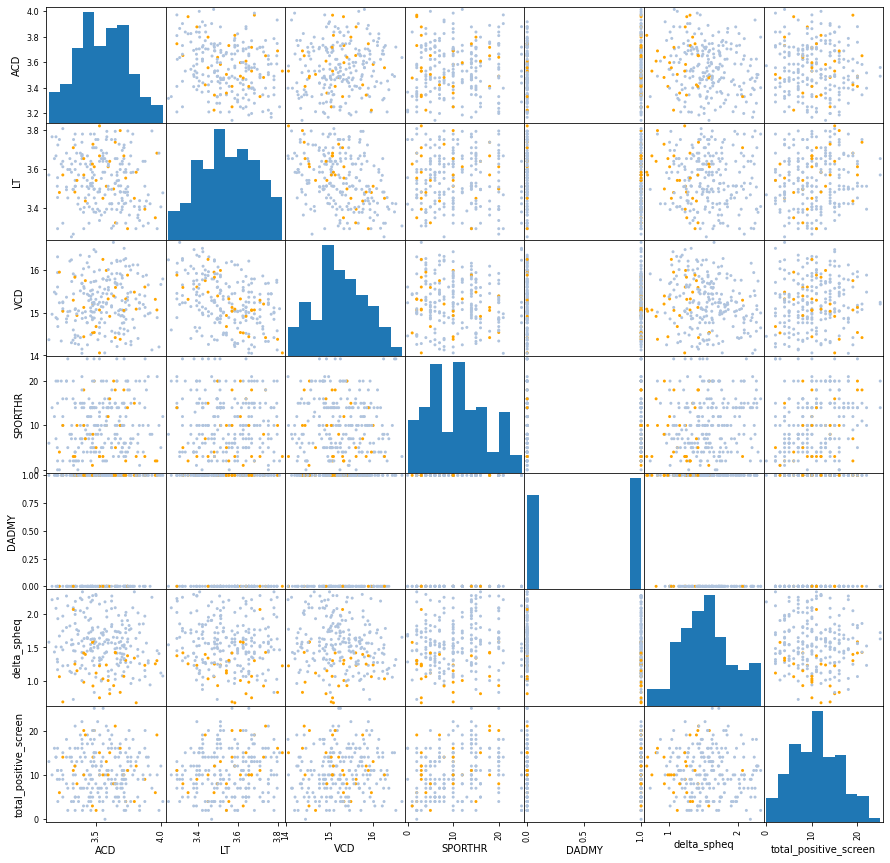

In [141]:
# original data
colors = {0:'lightsteelblue', 1:'orange'}
pd.plotting.scatter_matrix(X_train, alpha=1, figsize=(15,15), c=y_train.map(colors) );

## Balancing Data - RandomOverSampler

In [8]:
# Compared to the raw data scatter, the below scatter plot shows the datapoints just duplicated and plotted on top
# Note that the raw data scatter has no transparency while all the other charts below have alpha=0.2
# This was done so the effects of duplicated datapoints could be identified
# In theory, only the minority class is being duplicated but this could cause some overfitting.  
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

In [9]:
print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_ros))

Original dataset shape Counter({0: 210, 1: 30})
Resample dataset shape Counter({0: 210, 1: 210})


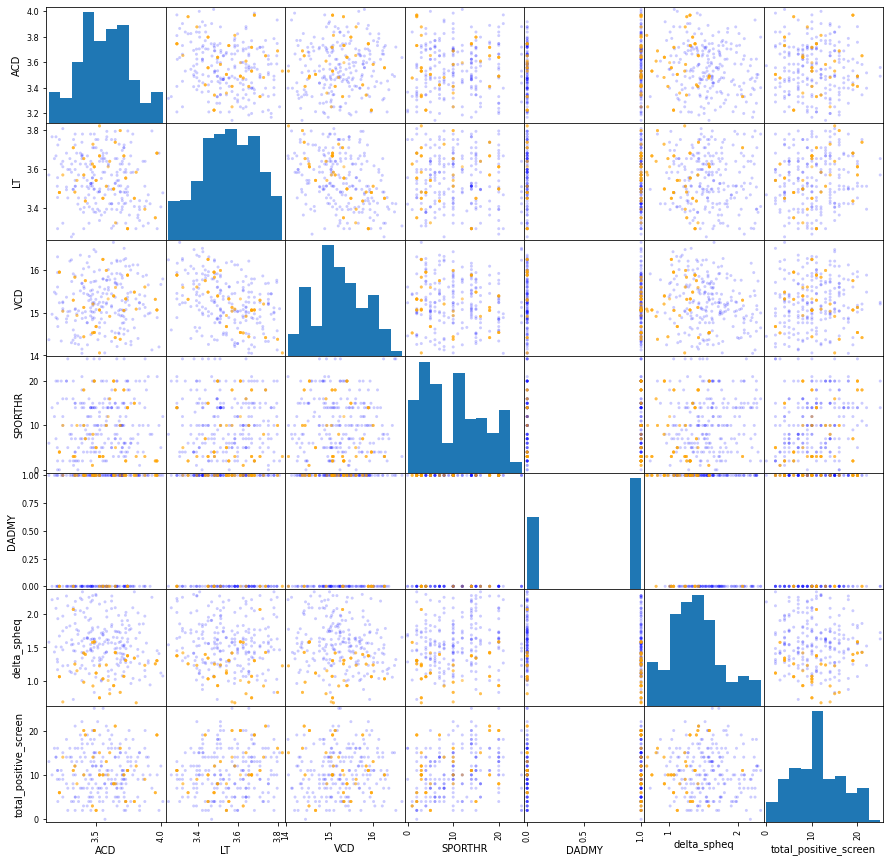

In [38]:
# balanced data
colors = {0:'blue', 1:'orange'}
pd.plotting.scatter_matrix(X_ros, alpha=0.2, figsize=(15,15), c=y_ros.map(colors) );

In [39]:
X_ros.describe()

,ACD,LT,VCD,SPORTHR,DADMY,delta_spheq,total_positive_screen
count,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000
mean,3.570038,3.551693,15.243190,9.814286,0.604762,1.395745,10.930952
std,0.195037,0.134270,0.565091,6.386799,0.489485,0.373945,5.313781
min,3.144000,3.252000,14.050000,0.000000,0.000000,0.678000,0.000000
25%,3.422000,3.450000,14.890000,4.000000,0.000000,1.120000,7.000000
50%,3.556000,3.554000,15.240000,10.000000,1.000000,1.377000,10.000000
75%,3.716000,3.654000,15.690000,15.000000,1.000000,1.584000,15.000000
max,4.013000,3.822000,16.660000,25.000000,1.000000,2.327000,25.000000


## Balancing Data - SMOTE
- synthetic minority over-sampling technique

In [142]:
# Compared to the raw data scatter, the data is spread but very close to the existing datapoints
# Theoretically, there should be more points between the existing points such that `almost narrow paths` are created between the original samples
oversample = SMOTE()
X_smote, y_smote = oversample.fit_resample(X_train, y_train)

In [143]:
print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({0: 210, 1: 30})
Resample dataset shape Counter({0: 210, 1: 210})


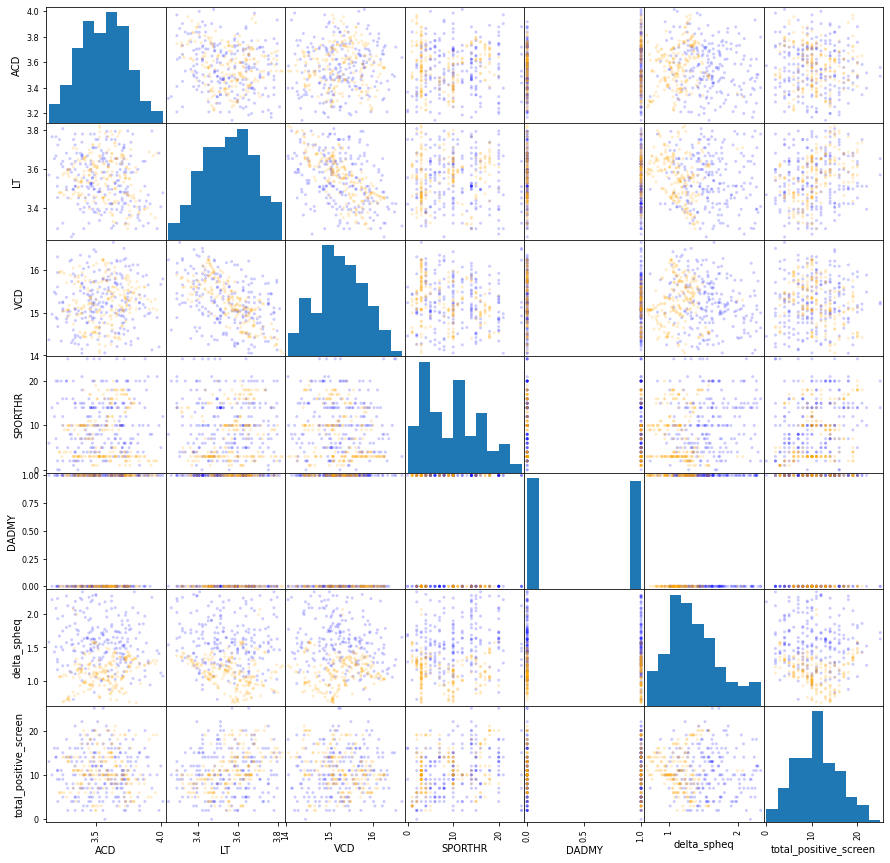

In [144]:
# balanced data
colors = {0:'blue', 1:'orange'}
pd.plotting.scatter_matrix(X_smote, alpha=0.2, figsize=(15,15), c=y_smote.map(colors) );

## Balacing Data - SMOTE with Undersampling

In [145]:
# Compared to the raw data scatter, the below scatter plot shows the datapoints scattered but there still exists an imbalance
# The dataset is smaller since the minority class was increasted and the majority class descreased in samples
# The distributions have some signficant differences
# In theory, the new samples will not follow a narrow path but a broad path giving it an appearance of randomness. 
# the new samples can also veer toward other paths if the paths become close to each other.  This can cause changes in the distributions.  
# This is probably a good method if the dataset is large and highly imbalanced initially.  

print('Original dataset shape', Counter(y_train))
print('Minority fraction of entire dataset:  ', Counter(y_train)[1]/(Counter(y_train)[0]+Counter(y_train)[1]))

Original dataset shape Counter({0: 210, 1: 30})
Minority fraction of entire dataset:   0.125


In [146]:
# sampling_strategy 
# - total number of samples increases
# - minority class changes from 30 to 84 and majority remains at 210.
# - Math:  sampling_strategy_input=(30+x)/210=0.4 then minority_samples=30+x

# To make it easier, lets enter how much of the overall datast you want the minority class to be
minority_fraction_minority_insert = 0.2
over_sampling_strategy = minority_fraction_minority_insert/(1-minority_fraction_minority_insert)

# create oversampling of minority class plan
over = SMOTE(sampling_strategy=over_sampling_strategy)

# sampling_strategy 
# - total number of samples decreases
# - minority class remains at 84 but the majority class decreases from 210 to 168.
# - Math:  84/(210-x)=0.5 then majority_samples=210-x

# To make it easier,, lets enter how much of the overall dataset you want the minority class to be
minority_fraction_majority_remove = 0.30
under_sampling_strategy = (1/minority_fraction_majority_remove - 1)**-1


under = RandomUnderSampler(sampling_strategy=under_sampling_strategy)

In [147]:
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [148]:
# transform the dataset
X_under_smote, y_under_smote = pipeline.fit_resample(X_train, y_train)

In [149]:
print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_under_smote))

Original dataset shape Counter({0: 210, 1: 30})
Resample dataset shape Counter({0: 121, 1: 52})


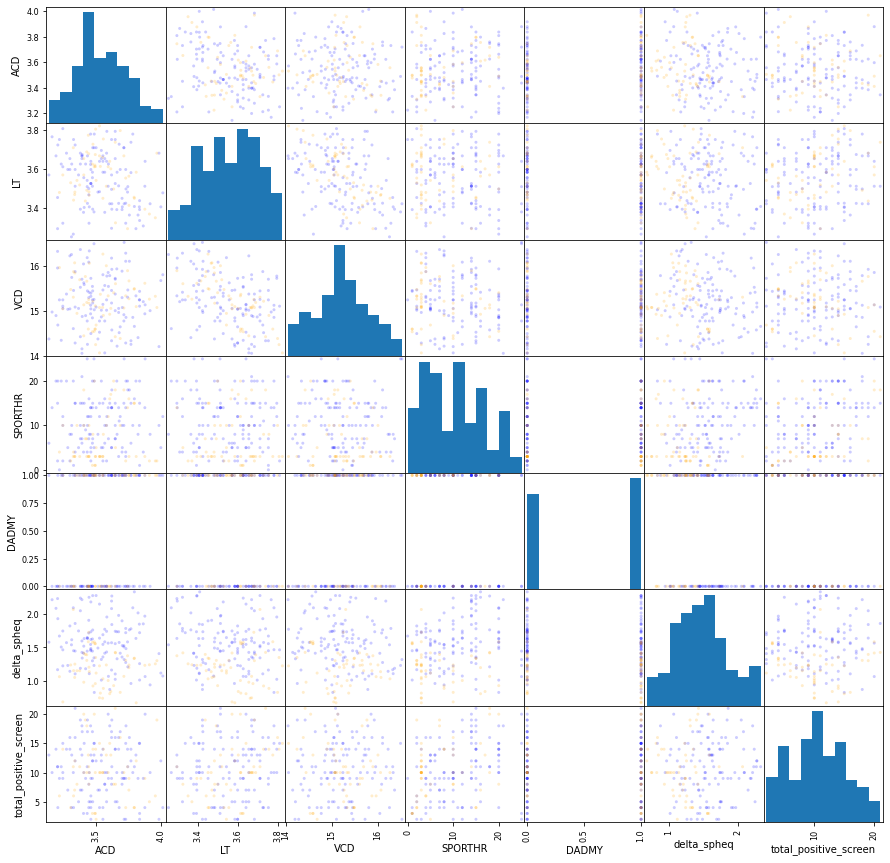

In [150]:
# balanced data
colors = {0:'blue', 1:'orange'}
pd.plotting.scatter_matrix(X_under_smote, alpha=0.2, figsize=(15,15), c=y_under_smote.map(colors) );

## Balancing Data - Sampling Low Density Areas
- Adaptive Synthetic Sampling

In [151]:
# Compared to the raw data scatter, the below scatter plot shows the datapoints spread but similar to the SMOTE method
# In theory, it adds samples to the low density areas and does not change the high density areas
oversample = ADASYN()
X_low_density, y_low_density = oversample.fit_resample(X_train, y_train)

In [152]:
print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_low_density))

Original dataset shape Counter({0: 210, 1: 30})
Resample dataset shape Counter({0: 210, 1: 209})


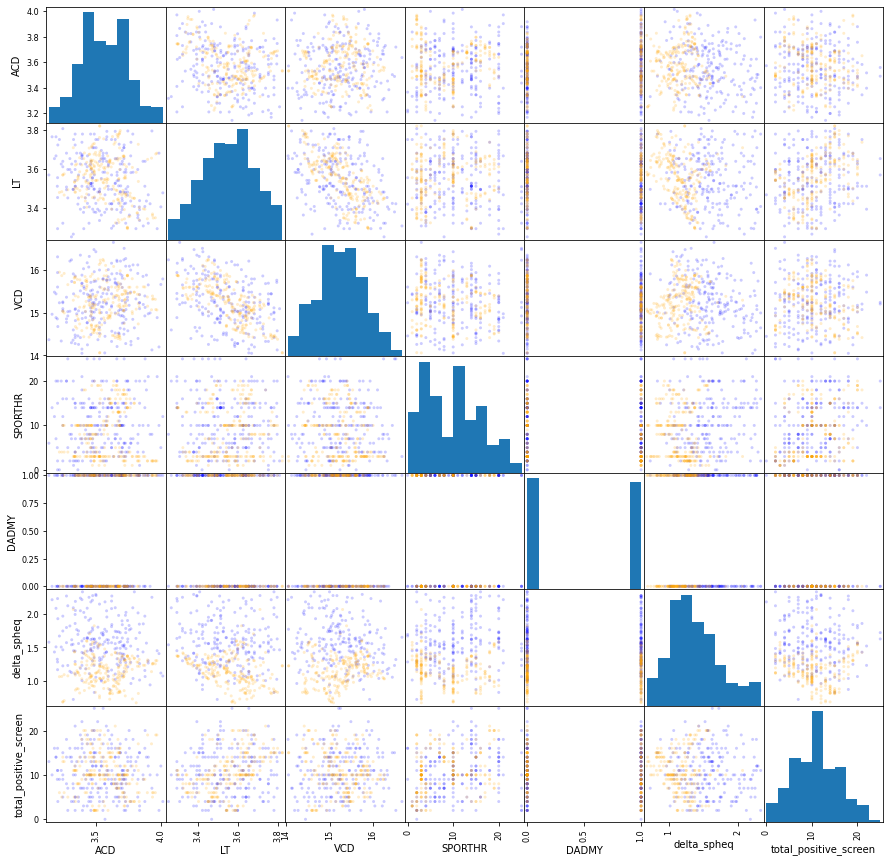

In [153]:
# balanced data
colors = {0:'blue', 1:'orange'}
pd.plotting.scatter_matrix(X_low_density, alpha=0.2, figsize=(15,15), c=y_low_density.map(colors) );

## Balancing Data - Oversampling Misclassified

In [154]:
# Compared to the raw data scatter, the below scatter plot shows the datapoints spread but less drastically
# Often used to identify hard to classify datapoints.  The models that work well are KNN and SVM
# In theory, samples are added from the misclassified minority class as identified by KNN.  New samples are added along the 
# decision border but not within a boundary of majority class samples.  This prevents paths from forming to outliers.
# Note:  There is also a SVMSMOTE() which uses SVC to find the misclassified.

oversample = BorderlineSMOTE()
X_over_misc, y_over_misc = oversample.fit_resample(X_train, y_train)

In [134]:
print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_over_misc))

Original dataset shape Counter({0: 210, 1: 30})
Resample dataset shape Counter({0: 210, 1: 210})


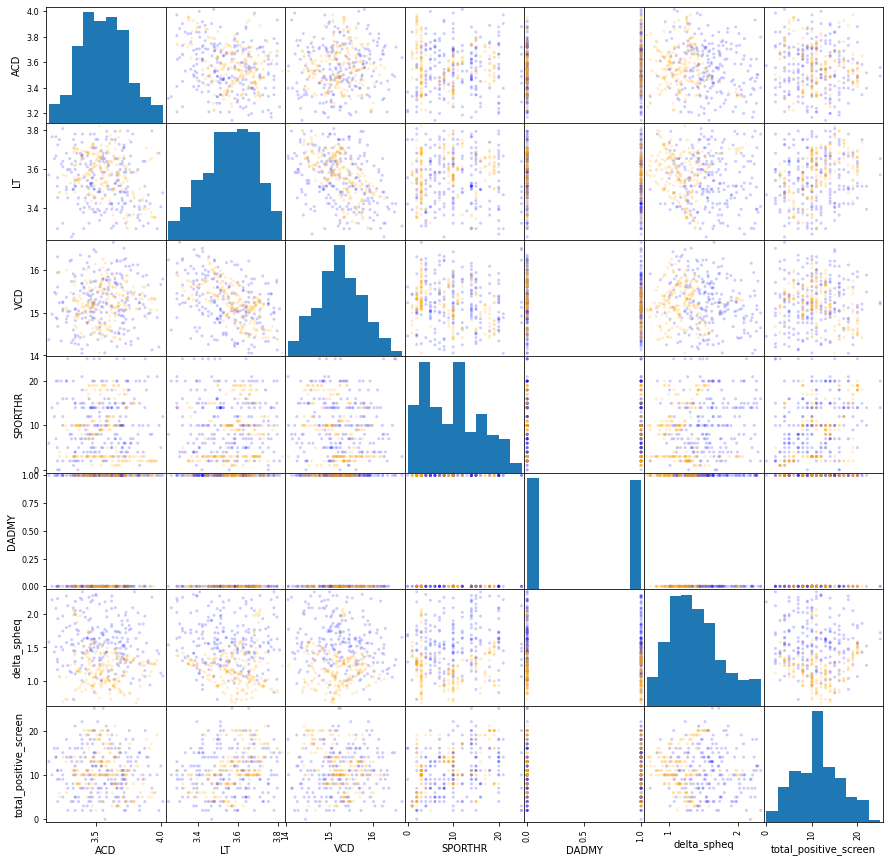

In [135]:
# balanced data
colors = {0:'blue', 1:'orange'}
pd.plotting.scatter_matrix(X_over_misc, alpha=0.2, figsize=(15,15), c=y_over_misc.map(colors) );

## SMOTE-NC - Used for mixed datatypes like Nominal and Continuous
- To Be Continued

## Other Methods
*  Imbalancelearn NearMiss() - uses KNN to undersample
*  Imbalancelearn CondensedNearestNeighbor() aka CNN - uses KNN to undersample but uses the misclassified majority class to penalize
*  Imbalancelearn TomekLinks() - Similar to CNN but uses redundant samples - doesn't appear to do a good job of balancing.


## Model with Cross Validation

In [175]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from statistics import mean, mode

In [177]:
model = DecisionTreeClassifier()
# evaluate pipeline
# for 5 fold cv, repeat ~100 times; for 10 fold cv, repeat ~50 times
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=100, random_state=1)
scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print(f'Mode of Scores: {mode(np.round(scores,2))}')
print("--------"*10)
print('Mean ROC AUC: %.3f' % mean(scores))

Mode of Scores: 0.62
--------------------------------------------------------------------------------
Mean ROC AUC: 0.625


In [168]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [171]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92        23
           1       0.50      0.25      0.33         4

    accuracy                           0.85        27
   macro avg       0.69      0.60      0.62        27
weighted avg       0.82      0.85      0.83        27



## Pipeline with Cross Validation
- Good explanation of stratified sampling - https://medium.com/sfu-cspmp/surviving-in-a-random-forest-with-imbalanced-datasets-b98b963d52eb

In [178]:
steps = [('over', SMOTE()), ('model', DecisionTreeClassifier())]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.635


In [185]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [186]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92        23
           1       0.50      0.25      0.33         4

    accuracy                           0.85        27
   macro avg       0.69      0.60      0.62        27
weighted avg       0.82      0.85      0.83        27



## Pipeline with Random Forest (imbalanced)

In [181]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate

In [182]:
irfc = RandomForestClassifier(n_estimators=150, random_state=0)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scoring = ('f1', 'recall', 'precision', 'roc_auc')

steps = [('model', irfc)]
pipeline = Pipeline(steps=steps)

In [183]:
#Evaluate irfc model
scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv)

C:\Users\ejwda\Anaconda3\envs\PythonDataS2022\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ejwda\Anaconda3\envs\PythonDataS2022\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ejwda\Anaconda3\envs\PythonDataS2022\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ejwda\Anaconda3\envs\PythonDataS2022\lib\site-

In [184]:
from statistics import mean
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))
print('AUC: %.3f' % mean(scores['test_roc_auc']))

Mean f1: 0.170
Mean recall: 0.122
Mean precision: 0.300
AUC: 0.755


In [187]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [188]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92        23
           1       0.50      0.25      0.33         4

    accuracy                           0.85        27
   macro avg       0.69      0.60      0.62        27
weighted avg       0.82      0.85      0.83        27



## Pipeline with Random Forest (imbalanced)

In [189]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [197]:
brfc = BalancedRandomForestClassifier(n_estimators=150, random_state=2)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=2)
scoring1 = ('f1', 'recall', 'precision', 'roc_auc')

steps1 = [('model1', brfc)]
pipeline = Pipeline(steps=steps1)

In [198]:
X_train.values

array([[ 3.66400003,  3.56800008, 16.20999908, ...,  0.        ,
         1.41600001,  3.        ],
       [ 3.91599989,  3.42199993, 15.        , ...,  0.        ,
         0.94400001, 10.        ],
       [ 3.83400011,  3.4059999 , 15.23999977, ...,  1.        ,
         1.847     , 15.        ],
       ...,
       [ 3.55599999,  3.45000005, 16.26000023, ...,  0.        ,
         1.03400001, 10.        ],
       [ 3.398     ,  3.67499995, 14.86999989, ...,  0.        ,
         1.343     , 17.        ],
       [ 3.49000001,  3.77999997, 15.02000046, ...,  1.        ,
         0.832     , 15.        ]])

In [199]:
y_train.shape

(240,)

In [200]:
#Evaluate SRF model
# Note needed to upgrade imbalance-learn to at least 0.9.1 and scikit-learn to at least 1.1.1
scores = cross_validate(pipeline, X_train.values, y_train.values, cv=cv, scoring=scoring1)
#brfc.fit(X_train.values.reshape(-1, 1), y_train)

In [202]:
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))
print('Mean AUC: %.3f' % mean(scores['test_roc_auc']))

Mean f1: 0.367
Mean recall: 0.700
Mean precision: 0.255
Mean AUC: 0.773


In [203]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [204]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92        23
           1       0.50      0.25      0.33         4

    accuracy                           0.85        27
   macro avg       0.69      0.60      0.62        27
weighted avg       0.82      0.85      0.83        27

